#  Nelinearna jednostavna regresija i višestruka regresija

In [374]:
# VIF - korelacijska matrica
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# 1. Učitavanje i osnovno čišćenje podataka

In [375]:
df = pd.read_csv("Housing.csv")
print(df.info())
# Skup podataka sastoji se od 545 primjera i 13 stupaca.
# Iz not-null stupca vidljivo je da nema nedostajućih vrijednosti.
# mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatu - kategoričke vrijednosti, ostale su numeričke

df.head()
# Skup podataka sadrži cijenu svake kuće i što sadrži (sobu za goste, koliko mjesta za parkiranje, koliko namještaja ima, spavaćih soba...)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# 2. Deskriptivna statistika

In [376]:
print(df.describe())

# Apsolutna srednja vrijednost cijene je 4766729 dolara s odstupanjem 1870440. Najmanja cijena stana je 1750000 dolara, a najveća 13300000. 25% Stanova je skuplje od 3430000, 75% stanova je jeftinije od 5740000.

              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000  


Text(0, 0.5, 'parkirna mjesta')

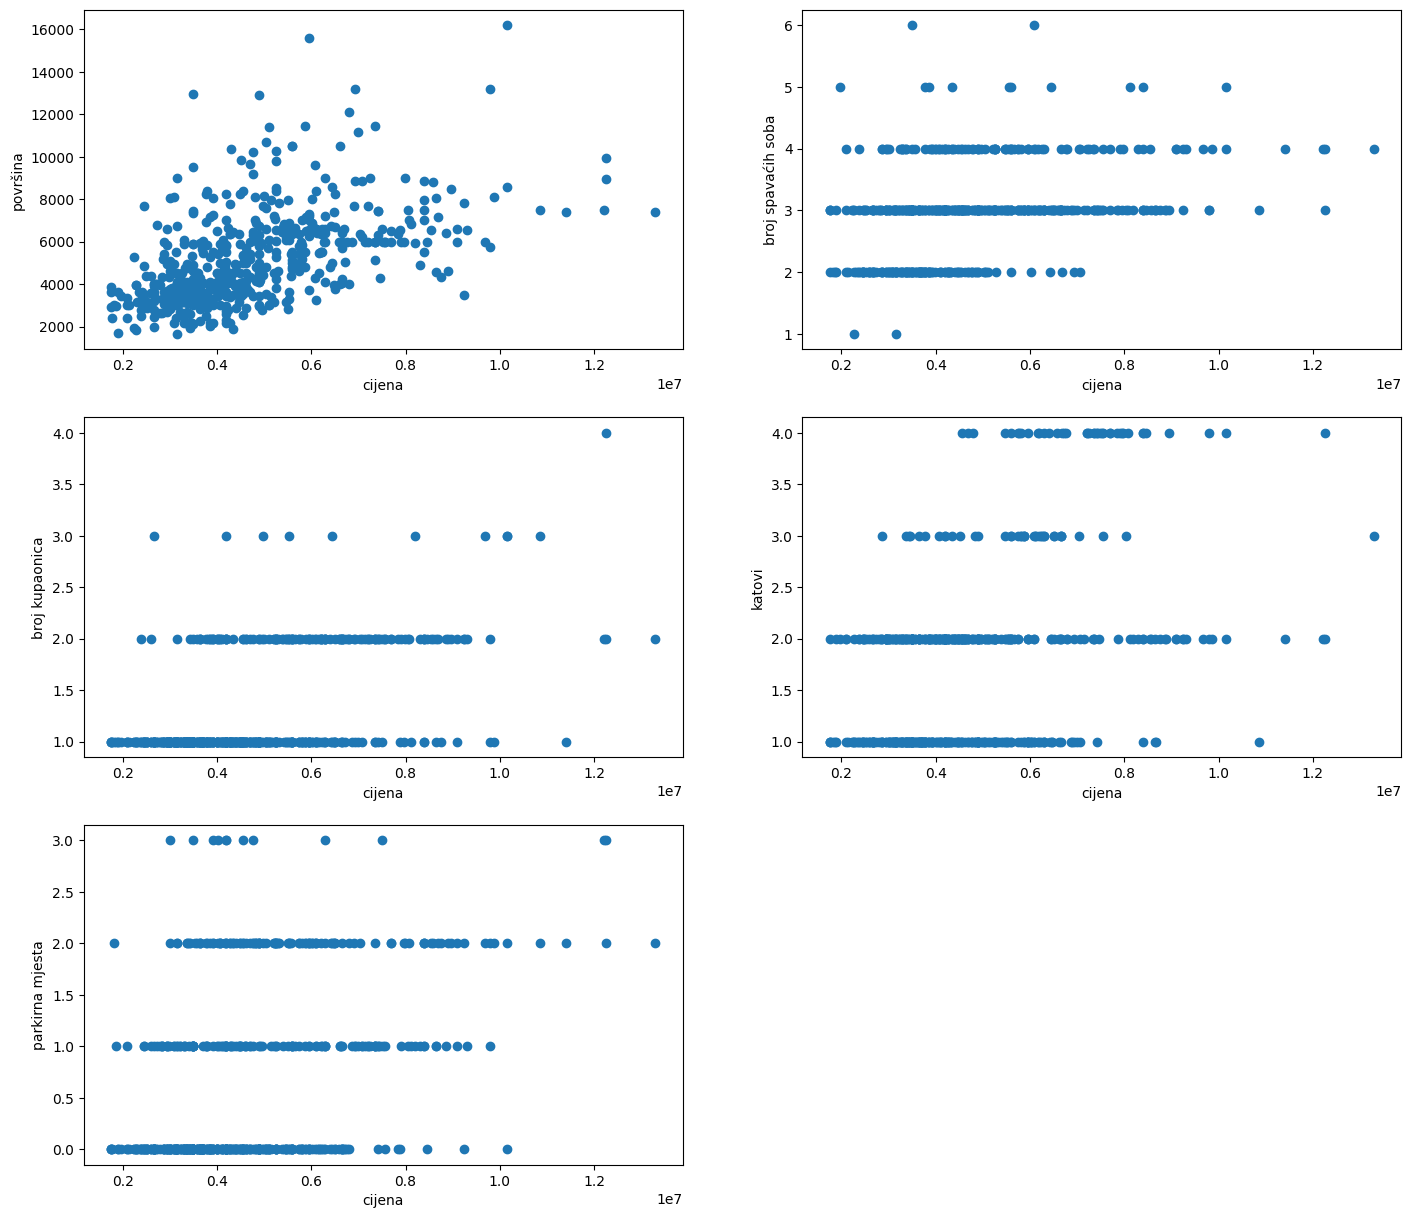

In [377]:
plt.figure(figsize=(17,15))

plt.subplot(3,2,1)
plt.scatter(df['price'], df['area'])
plt.xlabel("cijena")
plt.ylabel("površina")

plt.subplot(3,2,2)
plt.scatter(df['price'], df['bedrooms'])
plt.xlabel("cijena")
plt.ylabel("broj spavaćih soba")

plt.subplot(3,2,3)
plt.scatter(df['price'], df['bathrooms'])
plt.xlabel("cijena")
plt.ylabel("broj kupaonica")

plt.subplot(3,2,4)
plt.scatter(df['price'], df['stories'])
plt.xlabel("cijena")
plt.ylabel("katovi")

plt.subplot(3,2,5)
plt.scatter(df['price'], df['parking'])
plt.xlabel("cijena")
plt.ylabel("parkirna mjesta")

# Površina je kontinuirana varijabla, dok su ostale diskretne. Veća površina obično znači veća cijena stana, iako postoje iznimke. Manji broj spavaćih soba najčešće znači manja cijena (iako također postoje iznimke, moguće da su sobe u lošijem stanju),
# dok je za veći broj soba rason širok. Prema ostalim grafovima teško je procijeniti povezanost.

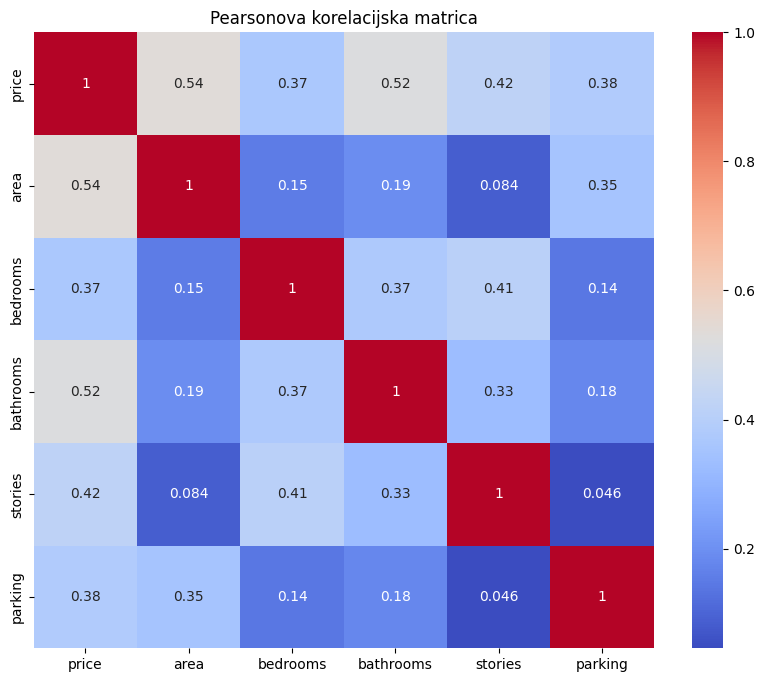

In [378]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

corr_pearson = df[num_cols].corr(method="pearson")

plt.figure(figsize=(10,8))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm')
plt.title("Pearsonova korelacijska matrica")
plt.show()

# Cijena ima najveću korelaciju s površinom i brojem kupaonica (pozitivnu - veće vrijednosti tih stupaca znače veću cijenu).
# Najslabija korelacija je s brojem spavaćih soba (pretpostavljam da cijena kuće više ovisi o drugim faktorima i stanju u kojem su sobe, njihovoj površini i slično).

# 3. Priprema varijabli za višestruku regresiju

In [379]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [380]:
y = df[['price']]

binary = ['mainroad', 'guestroom', 'basement','hotwaterheating', 'airconditioning']
df['mainroad'] = df['mainroad'].map({'yes': 1, 'no': 0})
df['guestroom'] = df['guestroom'].map({'yes': 1, 'no': 0})
df['basement'] = df['basement'].map({'yes': 1, 'no': 0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes': 1, 'no': 0})
df['airconditioning'] = df['airconditioning'].map({'yes': 1, 'no': 0})
df['prefarea'] = df['prefarea'].map({'yes': 1, 'no': 0})
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [381]:
df_encoded = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

df_encoded = df_encoded.rename(columns={'furnishingstatus_furnished': 'furnished', 'furnishingstatus_semi-furnished': 'semi-furnished', 'furnishingstatus_unfurnished': 'unfurnished'})

df_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [382]:
df_encoded['semi-furnished'] = df_encoded['semi-furnished'].map({True: 1, False: 0})
df_encoded['unfurnished'] = df_encoded['unfurnished'].map({True: 1, False: 0})

df_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [383]:
df_selected = df_encoded
df_selected = df_encoded = df_encoded.drop('price', axis=1)
df_selected.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [384]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_selected.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_selected.values, i)
    for i in range(len(df_selected.columns))
]
print(vif_data)

# Izbacila bih broj spavaćih soba jer je VIF vrijednost >10 (i ima nisku korelaciju s cijenom) te broj kupaonica jer je blizu 10 (iako ima umjerenu pozitivnu korelaciju sa cijenom).
# Area nisam planirala izbaciti jer ima visoku korelaciju sa cijenom, iako je VIF visok.

            feature        VIF
0              area   8.276447
1          bedrooms  16.652387
2         bathrooms   9.417643
3           stories   7.880730
4          mainroad   6.884806
5         guestroom   1.473234
6          basement   2.019858
7   hotwaterheating   1.091568
8   airconditioning   1.767753
9           parking   1.986400
10         prefarea   1.494211
11   semi-furnished   2.386831
12      unfurnished   2.008632


In [385]:
df_selected = df_selected.drop('bedrooms', axis=1)
df_selected = df_selected.drop('bathrooms', axis=1)

# 4.  Postavljanje modela višestruke linearne regresije (statsmodels)

In [386]:
x = df_selected
print(x.head())
print(y.head())

   area  stories  mainroad  guestroom  basement  hotwaterheating  \
0  7420        3         1          0         0                0   
1  8960        4         1          0         0                0   
2  9960        2         1          0         1                0   
3  7500        2         1          0         1                0   
4  7420        2         1          1         1                0   

   airconditioning  parking  prefarea  semi-furnished  unfurnished  
0                1        2         1               0            0  
1                1        3         0               0            0  
2                0        2         1               1            0  
3                1        3         1               0            0  
4                1        2         0               0            0  
      price
0  13300000
1  12250000
2  12250000
3  12215000
4  11410000


In [387]:
X_const = sm.add_constant(x)
model = sm.OLS(y, X_const).fit()
print(model.summary())

# jednadžba: y = 1.096e+06 + 276.53 * area + 6.768e+05 * mainroad + 3.503e+05 * guestroom + 5.133e+05 * basement + 1e+06 * airconditioning + 3.47e+05 * parking + 6.326e+05 * prefarea + -6.56e+04 * semi-furnished + -4.911e+05 * unfurnished

# jedine varijable koje nisu statistički značajne su semi-furnished i mainroad jer su im p-vrijednosti veće od 0.05 i zbog toga prihvaćamo hipotezu da nisu statistički značajne

# R2 - 61.8% varijabilnosti u cijeno objašnjeno je odabranim ulazima
# Adj. R2 - slično kao R2, ali penalizira nepotrebne varijable, to znači da se kao ulazi koristi nekoliko varijabli koje nisu potrebne
# F-statistika - model je statistički značajan i odabrani su dobri ulazi

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     78.53
Date:                Tue, 09 Dec 2025   Prob (F-statistic):          6.00e-104
Time:                        12:05:31   Log-Likelihood:                -8381.0
No. Observations:                 545   AIC:                         1.679e+04
Df Residuals:                     533   BIC:                         1.684e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.096e+06   2.26e+05     

# 5.  Provjera pretpostavki i vizualizacija rezultata

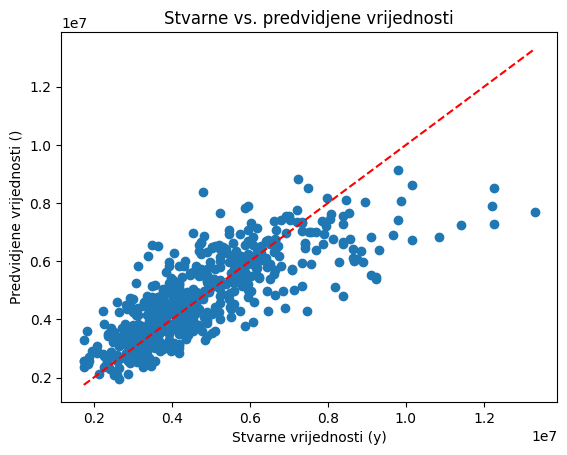

In [388]:
df["pred"] = model.fittedvalues
df["resid"] = model.resid

y_pred = model.predict(X_const)

plt.scatter(y, y_pred)
plt.xlabel("Stvarne vrijednosti (y)")
plt.ylabel("Predvidjene vrijednosti ()")
plt.title("Stvarne vs. predvidjene vrijednosti")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.show()





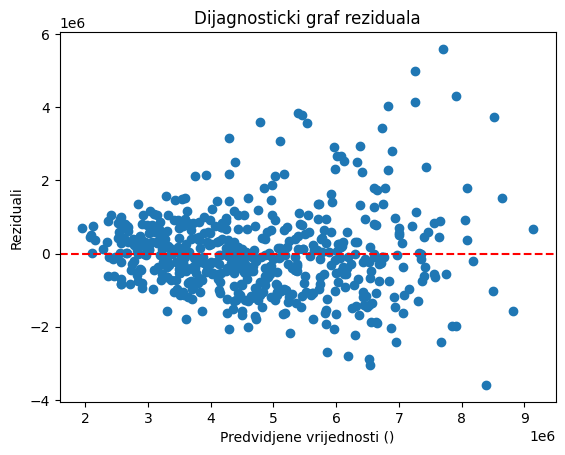

(545, 546)
(545,)


In [389]:
resid = y - y_pred
plt.scatter(y_pred, df["resid"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predvidjene vrijednosti ()")
plt.ylabel("Reziduali")
plt.title("Dijagnosticki graf reziduala")
plt.show()

print(resid.shape)
print(y_pred.shape)

# Ima oblik lijevka koji se širi prema desnoj strani. Smatram da niej prisutna homoskedastičnost jer reziduali na grafu ne izgledaju nasumično raspoređeno.

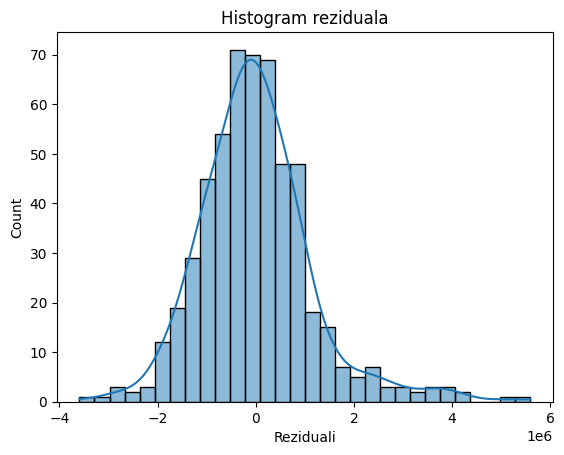

In [390]:
sns.histplot(df["resid"], kde=True)
plt.xlabel('Reziduali')
plt.title('Histogram reziduala')
plt.show()

# Distribucija reziduala je normalna.

# 6. Primjena modela i zaključak

In [398]:
x.head()

y_pred = model.predict([[2000, 2, 1, 1, 0, 1, 1, 2, 1, 0, 1]])

SyntaxError: invalid syntax (ipython-input-2442907696.py, line 3)